In [97]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path1p, "lib")
pwd_mat = os.path.join(os.path.join(path2p, "data/"), "sim_ds_mat")
pwd_h5 = os.path.join(os.path.join(path2p, "data/"), "sim_ds_h5")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

# User libraries
from matlab.matlab_yaro_lib import read_mat
from corr_lib import sprMat
from qt_wrapper import gui_fpath

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/experimental-bridge/nest-mesoscopic-metric-test/codes/lib


## 0. Loading data

In [89]:
# Read LVM file from command line
data_path = gui_fpath("Select data directory", data_path)
data, behaviour = read_mat(data_path)

# Get parameters
nTrials, nTimes, nChannels = data.shape
print("Loaded neuronal data with (nTrials, nTimes, nChannels)=", data.shape)

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg/mvg_5/mvg_5_2017_11_14_a
Loaded neuronal data with (nTrials, nTimes, nChannels)= (332, 201, 12)


# Cross-Correlation

First attempt at studying the data - autocorrelation. Should give indication at how well the data predicts itself

**Conclusions**:
* Why are there oscillations in the autocorrelation - ah, of course, because of decay-conv :)
* Data significantly autocorrelated - for most channel pairs it is best explained by 0-time-shift. Hence, it is useful to use an autoregressor to predict data

**TODO**:
* *[Priority Low]* See if global brain state can be subtracted somehow. Otherwise, there is significant ambiguity in what predicts what.
* *[Priority Low]* See if convolution time can be estimated from data. See if we can deconvolve 

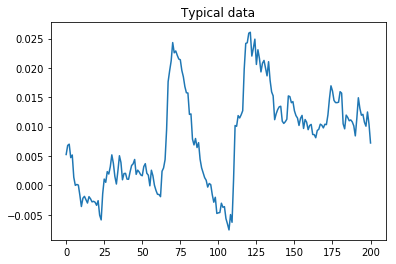

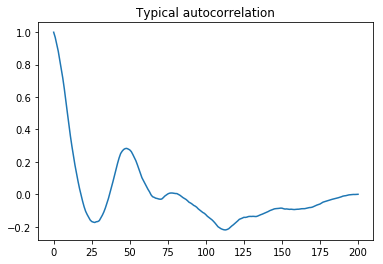

In [90]:
def crosscorr(x, y, withNorm = True):
    xdev = x - np.mean(x)
    ydev = y - np.mean(y)
    rez = np.correlate(xdev, ydev, mode='full')[x.size-1:]
    if withNorm:
        s2_x = np.correlate(xdev, xdev)
        s2_y = np.correlate(ydev, ydev)
        return rez / np.sqrt(s2_x * s2_y)
    else:
        return rez

plt.figure()
plt.title("Typical data")
plt.plot(data[0, :, 2])
plt.show()
    
plt.figure()
plt.title("Typical autocorrelation")
plt.plot(crosscorr(data[0, :, 2], data[0, :, 2]))
plt.show()

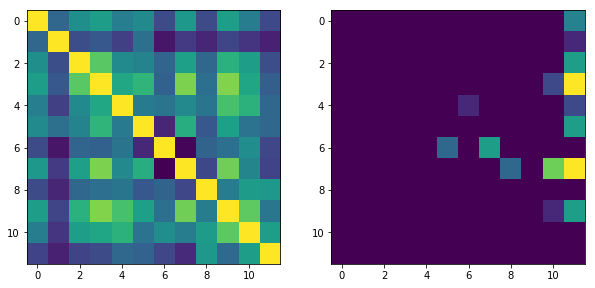

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.428490,0.571896,0.622531,0.510834,0.551061,0.341602,0.601381,0.345649,0.620652,0.506003,0.336888
1,0.428490,1.000000,0.353644,0.382640,0.309808,0.460620,0.199815,0.290887,0.239048,0.326481,0.279083,0.224949
2,0.571896,0.353644,1.000000,0.782969,0.551903,0.528889,0.426892,0.627576,0.435146,0.693260,0.625007,0.352202
3,0.622531,0.382640,0.782969,1.000000,0.660288,0.705795,0.410843,0.831158,0.457855,0.837417,0.652516,0.404470
4,0.510834,0.309808,0.551903,0.660288,1.000000,0.502325,0.475740,0.549756,0.479771,0.750295,0.694381,0.436362
5,0.551061,0.460620,0.528889,0.705795,0.502325,1.000000,0.238309,0.679166,0.380759,0.629918,0.472615,0.436002
6,0.341602,0.199815,0.426892,0.410843,0.475567,0.243817,1.000000,0.161577,0.417578,0.457816,0.564108,0.329825
7,0.601381,0.290887,0.627576,0.831158,0.549756,0.679166,0.147617,1.000000,0.333949,0.814219,0.536376,0.320741
8,0.345649,0.239048,0.435146,0.457855,0.479771,0.380759,0.417578,0.330532,1.000000,0.507069,0.617026,0.600922
9,0.620652,0.326481,0.693260,0.837417,0.750295,0.629918,0.457816,0.814219,0.507069,1.000000,0.788612,0.481082


,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,4
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,2,9
4,0,0,0,0,0,0,1,0,0,0,0,2
5,0,0,0,0,0,0,0,0,0,0,0,5
6,0,0,0,0,0,3,0,5,0,0,0,0
7,0,0,0,0,0,0,0,0,3,0,7,9
8,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,1,5


In [91]:
def crosscorr_multitrial(xx, yy):
    sumautox = np.sum([np.correlate(x - np.mean(x), x - np.mean(x)) for x in xx])
    sumautoy = np.sum([np.correlate(y - np.mean(y), y - np.mean(y)) for y in yy])
    sumcorr = np.sum([crosscorr(x, y, False) for x,y in zip(xx, yy)], axis=0)
    return sumcorr / np.sqrt(sumautox * sumautoy)
    

corr_max  = np.zeros((nChannels, nChannels))
corr_maxt = np.zeros((nChannels, nChannels), dtype=int)

for iCh in range(nChannels):
    for jCh in range(nChannels):
        corr = crosscorr_multitrial(data[:, :, iCh], data[:, :, jCh])#[:25]
        corr_maxt[iCh][jCh] = np.argmax(np.abs(corr))
        corr_max[iCh][jCh]  = corr[corr_maxt[iCh][jCh]]
        

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(corr_max)
ax[1].imshow(corr_maxt)
plt.show()

display(pd.DataFrame(corr_max))
display(pd.DataFrame(corr_maxt))

# Synchronization Coefficient

Let data be given by $Data_{ijk}$, where the coefficients stand for number of trials, time steps and channels respectively. Define the flattened version $Data_{ij}$, where time steps and trials have been flattened into a single index $i$. Then, define the correlation matrix as

$$C_{ij} = CORR(Data_{:, i}, Data_{:, j})$$

Define synchronization coefficient as

$$S = \frac{1}{N^2 - N}\sum_{ij} |C_{ij}| - \delta_{ij}$$

Plot Synchronization coefficient over days

Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_10_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_13_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_14_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_15_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_16_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_17_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_20_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_21_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_22_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_23_a
Reading Yaro data from /mnt/hifo_scratch1/Yaro/data_for_TE/mvg_48/mvg_4/mvg_4_2017_11_24_a

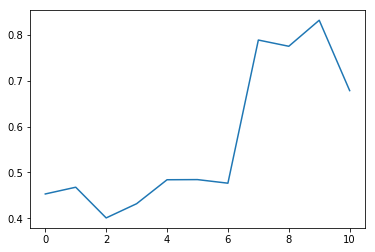

In [134]:
# Read LVM file from command line

synchrony_by_day = []

data_path_parent = gui_fpath("Select data parent directory", data_path)
subdirs = next(os.walk(data_path_parent))[1]
for subdir in subdirs:
    dirpath = os.path.join(data_path_parent, subdir)
#     print("Processing", dirpath)

    # Get data
    data, behaviour = read_mat(dirpath)
    
    # Get parameters
    nTrials, nTimes, nChannels = data.shape
    
    data2D = []
    
    for iCh in range(nChannels):
        dataChannel = []
        for iTr in range(nTrials):
            dataChannel += [data[iTr, :, iCh] - np.mean(data[iTr, :, iCh])]
        data2D += [np.array(dataChannel).flatten()]
            
    # Compute normalization variances
    s_data = [np.sqrt(np.correlate(d, d)) for d in data2D]
    
    # Compute correlation
    cr = np.zeros((nChannels, nChannels))
    for iCh in range(nChannels):
        for jCh in range(iCh+1, nChannels):
            cr[iCh][jCh] = np.correlate(data2D[iCh], data2D[jCh]) / (s_data[iCh] * s_data[jCh])
            
    synchrony_by_day += [np.sum(np.abs(cr)) * 2 / nChannels / (nChannels - 1)]
    
plt.figure()
plt.plot(synchrony_by_day)
plt.show()

# Deconvolution

We know that the observable $y$ is approximately the convolution of true variable $x$ with exponential decay. Let us estimate the decay constant. The true convolution equation states that

$$\tau \dot{y} = -y + x$$

We will assume that $x \sim \mathcal{N}(0, \Sigma)$. Using 2nd order time-differences, we get that

$$\tau \frac{y(t+\Delta t) - y(t-\Delta t)}{2 \Delta t} = -y(t) + x(t)$$

We will compute and plot this quantity

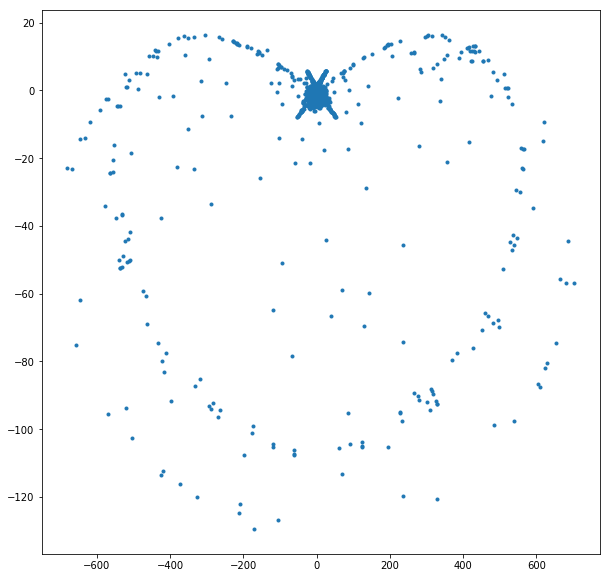

In [76]:
y_prim = []
rhs = []
for iTr in range(nTrials):
    for iCh in range(nChannels):#(nChannels):
        y = data[iTr, :, iCh] - np.mean(data[iTr, :, iCh])
#         y_prim += [y[1:] - y[:-1]]
#         rhs += [-(y[1:] + y[:-1])]
        y_prim += [(y[2:] - y[:-2])/(0.2)]
        rhs += [-y[1:-1]]

y_prim = np.array(y_prim).flatten()
rhs = np.array(rhs).flatten()

plt.figure(figsize = (10, 10))
# for yp, r in zip(y_prim, rhs):
plt.plot(y_prim, rhs, '.')
# plt.xlim(-0.05, 0.05)
# plt.ylim(-0.03, 0.03)
plt.show()